# CNN

In [1]:
from __future__ import print_function
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

## Loading data

In [2]:
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(transforms=[
    # Firstly, convert a PIL.Image or numpy.ndarray to tensor.
    transforms.ToTensor(),
    # Then, Normalize: Given mean: (R, G, B) and std: (R, G, B), will normalize
    # each channel of the torch.*Tensor, i.e. channel = (channel - mean) / std
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])  
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True,transform=transform)
# num_workers (int, optional) – how many subprocesses to use for data loading. 
# 0 means that the data will be loaded in the main process (default: 0)
trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=4, 
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=4, 
                                        shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


image shape: (3, 36, 138) ->  (36, 138, 3)
 ship truck  deer  ship


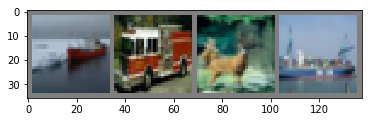

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
    
def show_img(img):
    # unormalize: channel = (channel - mean) / std =>
    # channel = channel * std + mean
    img = img * 0.5 + 0.5
    npimg = img.numpy()
    print("image shape:", npimg.shape, "-> ",np.transpose(npimg, (1, 2, 0)).shape)
    # X: M*N*3 – RGB, M = 32+2*2, N = 4*32+5*2
    plt.imshow(X=np.transpose(npimg, (1, 2, 0)))
    
# get some random training images
dataiter = iter(trainloader) # batch_size = 4
images, labels = dataiter.next()

# show images
show_img(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define the networks
![CNN Networks](./pictures/mnist.png)

In [5]:
class CnnNet(nn.Module):
    
    def __init__(self):
        super(CnnNet, self).__init__()
        # 3(RGB)@(32*32) -> 6@(28*28)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)
        # 6@(14*14) -> 16@(10*10)
        self.conv2 = nn.Conv2d(6, 16, 5, 1)
        # 16*5*5  -> 120
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # Activation funtion: ReLu
        x = F.relu(self.conv1(x))
        # Max pooling over a (2, 2) window for subsampling
        x = F.max_pool2d(x, kernel_size=(2, 2))
        # If the size is a square we can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Output layer
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        num_features = 1
        one_x_size = x.size()[1:]   # all dimensions except the batch dimension
        # print(one_x_size)
        for dim in one_x_size:
            num_features *= dim
        # print(num_features)
        return num_features

cnn_net = CnnNet()
print(cnn_net)

CnnNet (
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


In [6]:
params = list(cnn_net.parameters())
print(len(params))
print(params[0])  # conv1's weights

10
Parameter containing:
(0 ,0 ,.,.) = 
  0.0181 -0.0741 -0.0868  0.0912 -0.0392
  0.0319 -0.0564 -0.0949 -0.0063  0.0344
  0.0330  0.0750  0.0128  0.0617  0.0650
  0.0798  0.0493  0.0228  0.0949 -0.0784
  0.0192 -0.1017 -0.0140  0.0664 -0.0192

(0 ,1 ,.,.) = 
  0.0700 -0.1084 -0.1045 -0.0873  0.0265
 -0.0380 -0.0191 -0.0333 -0.0044  0.0487
 -0.0195 -0.0229 -0.0365  0.0282  0.0520
 -0.0428 -0.0383  0.0065  0.0034 -0.0135
 -0.0873 -0.0383 -0.0634  0.0001  0.0999

(0 ,2 ,.,.) = 
 -0.0097 -0.0003  0.0360  0.0696 -0.0321
  0.0048  0.0441  0.0462 -0.0627 -0.0296
  0.1011 -0.0485 -0.0348  0.0207 -0.0249
 -0.0105 -0.0830  0.0729  0.0263  0.0022
 -0.0270  0.0809  0.0420 -0.0398  0.0346

(1 ,0 ,.,.) = 
  0.0948 -0.1071  0.1131  0.0696  0.0766
  0.0027 -0.1039 -0.0903  0.1140  0.0966
 -0.1065  0.0459  0.0193  0.0368 -0.0218
 -0.0379  0.0005 -0.0125 -0.0123  0.0728
  0.0156 -0.0675 -0.0526 -0.1118 -0.0624

(1 ,1 ,.,.) = 
  0.1004 -0.0099  0.0605 -0.0632 -0.0924
  0.0327 -0.0344 -0.0564 -0.0423 -0

In [7]:
x = Variable(torch.randn(1, 3, 32,32))  # (batch_size, channels_size, image_size_x, image_size_y) 
print(x)
y = cnn_net(x) # or cnn_net.forward(x)
print(y)

Variable containing:
(0 ,0 ,.,.) = 
 -1.1430 -0.7030 -0.5593  ...   0.8817  1.3423  1.1922
 -1.8406 -1.8927 -0.6774  ...  -0.5937  1.0948 -0.0220
  0.8934  0.6300  1.2183  ...  -0.3693  1.0363  0.8582
           ...             ⋱             ...          
  0.6631 -1.4014  1.7669  ...  -0.2705 -0.2621  0.7387
  0.7840  0.4836 -0.6318  ...   1.2961 -0.1737  2.0576
  0.2832  1.9511 -0.1682  ...  -0.5727 -2.1228  2.1749

(0 ,1 ,.,.) = 
 -0.2996 -0.4241  1.0799  ...   1.2598 -0.3111 -1.2882
  1.4745 -1.1935  0.2095  ...   1.4058  1.0875 -0.9440
  0.5303 -0.7267 -0.0243  ...   1.1263  0.0457  1.2527
           ...             ⋱             ...          
 -0.5080 -1.5663 -1.4825  ...  -0.9414  1.2689 -0.6734
  1.4657 -0.3791  0.8302  ...  -2.0735 -0.9766 -1.0664
  0.2750  0.6998  1.1887  ...   1.0163 -2.2234 -0.2732

(0 ,2 ,.,.) = 
 -1.1991  0.2930 -0.7028  ...  -0.6533 -0.2122  0.7759
  0.4307 -0.5024 -0.4489  ...   0.7330  0.0679  1.7490
  3.4923 -1.3034 -1.7384  ...   0.1849 -1.6159 -0.55

## Define a loss function and Optimize

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=cnn_net.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [9]:
epoch_num = 2
for epoch in range(epoch_num):
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        # wrap them in Variable
        inputs, labels = Variable(images), Variable(labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        outputs = cnn_net(inputs)
        # backward
        loss = criterion(outputs, labels)
        loss.backward()
        # optimiz: step() can be called once the gradients are computed using backward().
        optimizer.step()
        
        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.160
[1,  4000] loss: 1.816
[1,  6000] loss: 1.660
[1,  8000] loss: 1.576
[1, 10000] loss: 1.515
[1, 12000] loss: 1.485
[2,  2000] loss: 1.398
[2,  4000] loss: 1.364
[2,  6000] loss: 1.339
[2,  8000] loss: 1.331
[2, 10000] loss: 1.287
[2, 12000] loss: 1.260
Finished Training


## Test

In [10]:
total, correct = 0, 0
for data in testloader:
    imgs, labels = data
    outputs = cnn_net(Variable(imgs))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [ ]:
class_total = [0] * 10
class_correct = [0] * 10
for data in testloader:
    imgs, labels = data
    outputs = cnn_net(Variable(imgs))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    # batch_size = 4
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))